# Microeconometrics Project by Fabian Balensiefer - 'Are Credit Markets Still Local? Evidence from Bank Branch Closings'

## Quick Reference
Scope of this project is to replicate a the study **"Are Credit Markets Still Local? Evidence from Bank Branch Closings."** written by **Hoai-Luu Q. Nguyen**  published in *AMERICAN ECONOMIC JOURNAL: APPLIED ECONOMICS VOL. 11, NO. 1, JANUARY 2019*. <br> <br>

Data and stata-files are provided by the American Economic Association:<br>
<href>https://www.aeaweb.org/articles?id=10.1257/app.20170543</href><br>



**Hyothesis:** Does the distance to bank branches effect credit allocation?<br>

**Identification Issue:** Openings and closings of bank branches are not random assignments<br>

**Idea:** Using the impact of post-merger branch closings to measure the effect on lending <br>
          => *Key assumption:* merger decision is exogenous to local economic conditions (census tract)
          
**Data:**

        * census tract -> macro- and household data on tract level
        * Summary of Deposits -> bank branch data
        * Report of Changes -> merger and branch closing 
        * HMDA and CRA -> lending data
        
**Method:** 

        1. IV – “exposure to post-merger consolidation” as instrument for closings
        2. DiD – to compare lending in exposed and control (census) tracts in the same county 

*Why does the author use two methods? - to allow for heterogeneity across tracts within a county (DiD)*

## Brief summary of Nguyen (2019)

The paper “Are Credit Markets Still Local? Evidence from Bank Branch Closings” by Nguyen (2019) established a novel approach for estimating the causal impact of bank branch closings on credit supply at branch level. Motivated by the question whether technological progress have changed the access to credit she is interested in estimating the local average treatment effect of bank branch closings. While other research focus on aggregate system wide shocks, Nguyen (2019) concentrates on a local approach. Thus, she is able to control for unobserved heterogeneity across different regions. 

Nguyen (2019) combines national data from four different sources. First, macro- and household data on tract level is provided by the census bureau. Data on bank branches are published in the Summary of Deposits, while merger and bank branch closings are recorded in the Report of Changes (both by FDIC). Lending data for private lending/ mortgages (HMDA) and commercial lending (CRA) came from the FFIEC. Finally, some additional macroeconomic data is used from the National Establishment Time-Series (NETS) by Walls and Associates. Thus, most of the used data is provided by US official institutions. Data is merged on bank- and tract level by using GIS software to map geographical locations. Tracts are defined by the census bureau as regions containing approximately 4000 inhabitants, while differing in size. The final sample consists of tracts based on exposure to large bank mergers in the period between 1999 and 2012. 

The Hypothesis of the paper, whether distance to bank branches effect credit allocation, is analyzed in a quasi-experimental research design. A Difference-in-Differences framework allows to control for time-varying trends across tracts within the same county. Instrumenting bank branch closings with bank mergers addresses the endogeneity issue of bank branch closings. More about the identification will be discussed in the following section of this replication study. 

Results of Nguyen (2019), support the hypothesis that distance to bank branches still affect access to credit. Findings suggest, that “closings lead to a persistent decline in local small business lending” (Nguyen 2019). The effect on private lending seem to be of temporary nature (since this temporary decline is insignificant, we cannot infer any results).  
Nguyen (2019) concludes, that “distance matters not only because it improves accessibility, but also because it reduces the costs of transmitting information”.  This is in line with theoretical findings from Akerlof (1970), Stiglitz and Weiss (1981), which find that credit markets are subject to informational asymmetries. Surprisingly, after major improvements in information technologies in the past decades these findings still indicating to hold.

## Causal Graph and Identification Strategy

### Causal Graph 

![](graphs/causal_graph.png)

    * D - treatment variable "bank branch closings"
    * Y - dependent variable "lending activity"
    * E - general economic controls (county level)
    * X - local economic controls (tract level)
    * M - instrument "merger activity"
    * U - unobserved drivers of lending activity
    
The causal graph above pins down the relationships between banking and lending. There are multiple collider varibales, backdoorpaths, confounding varibales and reverse causality issues need to be solved to show causality. 

First consider our variable of interest, lending activity. Since credit is an equilibirum concept, 
its very difficult to disentangle whether a change in lending activity is driven by a change in credit demand or supply. Second our treatment variable, bank branch closings, has an issue of reverse causality with lending activity. One can argue, that less demand for credit is affecting banks decision to close a branch in a certain location. While, we are testing whether the closing of a branch in a certain location affects credit availability. This issues, can be solved by instrumenting bank branch closing with merger activity. The author argues, that the decision to close a branch after a merger is more driven by merger activity less then by local demand of lending. By controlling for bankspecific characteristics and general economic conditions the backdoor paths over $X$ and $E$ are blocked. Thus, the exogeneity and relevance conditions should be fullfilled.

Finally, two backdoorpaths need to be blocked. Which is done by controlling for general- ($E$) and local economic ($L$) conditions.

### Identification 

Since tracts and counties are differ in various characteristics, a concern on heterogeneity across tracts arises. The IV-approach is not able to control for such unobserved time-varying individual tract characteristics. Therefore the author expands the analysis by a difference in differences approach (DiD). This panel data method allows to account for heterogeneity. The idea is to compair treated and non-treated tracts within a county, while controlling for tract and county-by-year fixed-effects. General economic conditions within a county should be compairable, such that heterogeneity is not driving the results anymore. 

In the first step the author tests whether branch closing affects local credit supply.
Since we can not rule out potential simultaneity issues between branch closing and credit supply, the athor uses an IV approach.
$$\text{Close}_{it} = \kappa_i + \psi_t + \rho X_{it} + \beta_e \text{Expose}_{it} + \omega_{it}$$
$$ y_{it} = \alpha_i + \gamma_t + \lambda X_{it} + \beta_c \text{Close}_{it} + \epsilon_{it} $$
Further to address the issue that the decision for a merger is not turely exogenous Nguyen expands her anaylsis by an Difference-in-Differences Approach. To compare tracts who experienced a merger and tracts without (treated and control tracts/groups) within a county. 
$$y_{icmt} = \alpha_i + (\gamma_t \times \sigma_c) + X_i \beta_t + \sum_{\tau} \delta_{\tau} (D_{mt}^{\tau} \times \text{Expose}_{icm}) + \epsilon_{icmt}$$
Where tract $i$ in county $c$ experienced merger $m$ in year $t$. $D_{mt}^{\tau}$ is a dummy variable equals one in year $t$ and $\tau$ years after merger $m$ is approved. The reduced model is independent of $\tau$, thus:
$$y_{icmt} = \alpha_i + (\gamma_t \times \sigma_c) + X_i \beta_t + \delta_{\text{POST}} (\text{POST}_{mt} \times \text{Closure}_{icm}) + \epsilon_{icmt}$$

In [1]:
%reset -f
%clear
%load_ext autoreload

# preface loading packages required for Python Data Science
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from auxiliary import *
from linearmodels import PanelOLS
from linearmodels.iv import IV2SLS
warnings.filterwarnings('ignore')

%matplotlib inline

## Replication of Summary Statistics

...

In [2]:
# Table 1: Merger Sample
print(tab1().to_string(index=False))

                                   Buyer                                             Target  Year approved
 Manufacturers and Traders Trust Company                                      Allfirst Bank           2003
   Bank of America, National Association                                Fleet National Bank           2004
                      National City Bank                                 The Provident Bank           2004
                            Regions Bank          Union Planters Bank, National Association           2004
                     JPMorgan Chase Bank                     Bank One, National Association           2004
                         North Fork Bank                                    GreenPoint Bank           2004
                           SunTrust Bank                          National Bank of Commerce           2004
     Wachovia Bank, National Association                                    SouthTrust Bank           2004
                          Sovereign B

In [3]:
# Table 2: Merger Sammary Statistics
print(tab2().to_string(index=False))

               Variable   Median       Min         Max
           Total assets 81954710  25963401  1252402412
               Branches      696       254        5569
    States of operation        8         1          31
 Countries of operation      182        18         692
           Total assets 25955711  10426963   245783000
               Branches      277        28        1482
    States of operation        6         1          13
 Countries of operation       54         7         202


In [4]:
# todo add standard devidations in brackets
# Table 3: Summary Statistics for Exposed and Control Tracts
pd.options.display.float_format = '{:.3f}'.format
print(tab3().to_string(index=False))

           Variable   Exposed  All other  p-value 01   Control  p-value 02
         popdensity  2575.407   7206.310       0.000  6105.754       0.000
             poptot  5761.404   4571.781       0.000  5387.571       0.013
          medincome 44223.772  45451.951       0.304 52171.479       0.000
          pminority     0.211      0.386       0.000     0.238       0.039
           pcollege     0.309      0.256       0.000     0.341       0.002
          pmortgage     0.688      0.708       0.014     0.721       0.000
            pincome   114.473    101.963       0.000   118.616       0.149
 cont_totalbranches     5.849      1.141       0.000     3.816       0.000
      cont_brgrowth     0.053      0.030       0.011     0.065       0.185
   cont_NumSBL_Rev1   103.400     54.335       0.000    88.947       0.000
  cont_total_origin   277.220    227.091       0.000   281.016       0.723
                Obs   386.000  18027.000         nan  3087.000         nan


In [5]:
# Table 4: Representativeness of the Merger Sample
pd.options.display.float_format = '{:.3f}'.format
print(tab4().to_string(index=False))

      Variable       All  Closings    Merger
    popdensity  4032.403  3615.265  6166.240
        poptot  4687.897  4941.796  5401.217
     medincome 44829.351 45248.801 51803.494
     pminority     0.195     0.197     0.234
      pcollege     0.247     0.272     0.337
     pmortgage     0.668     0.684     0.716
 totalbranches     2.611     3.893     4.095
      brgrowth     0.125     0.153     0.071
   NumSBL_Rev1    89.156   106.479    91.880
  total_origin   317.562   342.827   281.857
       pincome   104.267   106.273   119.300
           Obs 37041.000  7768.000  3003.000


In [6]:
# Table 5: Complier Characteristics
pd.options.display.float_format = '{:.3f}'.format
print(tab5().to_string(index=False))

          Variables  ecomp  ratio
         popdensity 18.308  0.366
             poptot 57.533  1.151
          medincome 29.087  0.582
          pminority 60.262  1.205
           pcollege 47.011  0.940
          pmortgage 39.219  0.784
            pincome 41.426  0.829
 cont_totalbranches 86.497  1.730
      cont_brgrowth 49.612  0.992
   cont_NumSBL_Rev1 60.650  1.213
  cont_total_origin 48.051  0.961


## Replication of the Main Results

...

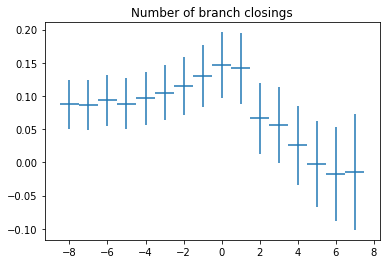

In [4]:
# Figure 2: Exposure to consolidation and the incidence of branch closings
mean=fig2()[0]
std=fig2()[1]
plt.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
plt.title('Number of branch closings')
plt.show()  

In [2]:
# Table 6: First-Stage and Reduced-Form estimates 
df = pd.read_stata('data/replication_input.dta')
df.drop_duplicates(keep='first', inplace=True)
df=df.assign(event_year=lambda df:df.year-df.yr_approve)
index=list(df)
df['group_timeID']= df.groupby(['state_fps', 'cnty_fps', 'year']).grouper.group_info[0]
df['indivID']= df.groupby(['state_fps', 'cnty_fps', 'tractstring']).grouper.group_info[0]
df['clustID']= df.groupby(['state_fps', 'cnty_fps']).grouper.group_info[0] 
dummy = pd.get_dummies(df['year'])
chars = ['poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
for i in chars:
    for j in range(1999,2014):
        name=i+str(j)
        df[name]=0
        df[name]=df[i].loc[df['year']==j]
df = df.fillna(0)
dftemp = df.filter(regex='poptot|popdensity|pminority|pcollege|medincome|pincome|cont_totalbranches|cont_brgrowth')
dftemp = dftemp.drop(chars, axis=1)  
controllist = list(dftemp)
controls = "+".join(controllist)
#temp = df.groupby([i, 'year']).grouper.group_info[0]       
df.set_index(['indivID', 'group_timeID'], inplace=True)
dftest=df.copy()

In [3]:
dftest['eDl']=0
dftest['eDl'].loc[(dftest['event_year']<-1) & dftest['overlap']==1]=1
for i in range(0,7):
    dum='eD'+str(i)
    dftest[dum]=0
    dftest[dum].loc[(dftest['event_year']==i) & dftest['overlap']==1]=1

dftest['eDu']=0
dftest['eDu'].loc[(dftest['event_year']>6) & dftest['overlap']==1]=1
dummylist=list(dftest.filter(regex='eD'))
dummies="+".join(dummylist)
#model = 'num_closings ~ C(indivID)+C(group_timeID)+'+controls+'+'+dummies
#exog = dummylist + controllist
exog = dummylist
mod = PanelOLS(dftest.num_closings, dftest[exog], entity_effects=True, time_effects=True)
res=mod.fit()
#res = mod.fit(cov_type='clustered', cluster_entity=False)

#dftest.to_csv('test_csv.csv')
print(res.params)
#dftest.head()

eDl   -0.021393
eD0    0.058512
eD1    0.225970
eD2    0.023081
eD3    0.050242
eD4    0.024861
eD5   -0.003407
eD6   -0.033233
eDu   -0.025220
Name: parameter, dtype: float64


In [4]:
## estimates of column 1 (number of closings)
est_numclose= pd.DataFrame(columns=['beta', 'SE'], index=range(-1, 8))
beta=pd.DataFrame(index=range(-1, 8))
std=pd.DataFrame(index=range(-1, 8))
for i in range(0, 7):
    df['D'] = 0
    df.loc[(df['event_year'] >= i) & (df['overlap']==1) , 'D'] = 1
    exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
    mod = PanelOLS(df.num_closings, df[exog], entity_effects=False, time_effects=True)
    reg = mod.fit(cov_type='clustered', cluster_entity=True)
    beta[i]=reg.params['D']
    std[i]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] <= -1) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.num_closings, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[-1]=reg.params['D']
std[-1]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] >= 7) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.num_closings, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[7]=reg.params['D']
std[7]=reg.std_errors['D']
pd.options.display.float_format = '{:.3f}'.format
est_numclose['beta']=beta.T
est_numclose['SE']=std.T

In [5]:
## estimates of column 2 (total branches)
est_totalbranches= pd.DataFrame(columns=['beta', 'SE'], index=range(-1, 8))
beta=pd.DataFrame(index=range(-1, 8))
std=pd.DataFrame(index=range(-1, 8))
for i in range(0, 7):
    df['D'] = 0
    df.loc[(df['event_year'] >= i) & (df['overlap']==1) , 'D'] = 1
    exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
    mod = PanelOLS(df.totalbranches, df[exog], entity_effects=False, time_effects=True)
    reg = mod.fit(cov_type='clustered', cluster_entity=True)
    beta[i]=reg.params['D']
    std[i]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] <= -1) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.totalbranches, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[-1]=reg.params['D']
std[-1]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] >= 7) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.totalbranches, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[7]=reg.params['D']
std[7]=reg.std_errors['D']
pd.options.display.float_format = '{:.3f}'.format
est_totalbranches['beta']=beta.T
est_totalbranches['SE']=std.T

In [6]:
## estimates of column 3 (SBL origin)
est_SBLorigin= pd.DataFrame(columns=['beta', 'SE'], index=range(-1, 8))
beta=pd.DataFrame(index=range(-1, 8))
std=pd.DataFrame(index=range(-1, 8))
for i in range(0, 7):
    df['D'] = 0
    df.loc[(df['event_year'] >= i) & (df['overlap']==1) , 'D'] = 1
    exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
    mod = PanelOLS(df.NumSBL_Rev1, df[exog], entity_effects=False, time_effects=True)
    reg = mod.fit(cov_type='clustered', cluster_entity=True)
    beta[i]=reg.params['D']
    std[i]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] <= -1) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.NumSBL_Rev1, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[-1]=reg.params['D']
std[-1]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] >= 7) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.NumSBL_Rev1, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[7]=reg.params['D']
std[7]=reg.std_errors['D']
pd.options.display.float_format = '{:.3f}'.format
est_SBLorigin['beta']=beta.T
est_SBLorigin['SE']=std.T

In [7]:
## estimates of column 4 (Mortgage origin)
est_Morigin= pd.DataFrame(columns=['beta', 'SE'], index=range(-1, 8))
beta=pd.DataFrame(index=range(-1, 8))
std=pd.DataFrame(index=range(-1, 8))
for i in range(0, 7):
    df['D'] = 0
    df.loc[(df['event_year'] >= i) & (df['overlap']==1) , 'D'] = 1
    exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
    mod = PanelOLS(df.total_origin, df[exog], entity_effects=False, time_effects=True)
    reg = mod.fit(cov_type='clustered', cluster_entity=True)
    beta[i]=reg.params['D']
    std[i]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] <= -1) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.total_origin, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[-1]=reg.params['D']
std[-1]=reg.std_errors['D']
df['D'] = 0
df.loc[(df['event_year'] >= 7) & (df['overlap']==1) , 'D'] = 1
exog = ['D', 'poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
mod = PanelOLS(df.total_origin, df[exog], entity_effects=False, time_effects=True)
reg = mod.fit(cov_type='clustered', cluster_entity=True)
beta[7]=reg.params['D']
std[7]=reg.std_errors['D']
pd.options.display.float_format = '{:.3f}'.format
est_Morigin['beta']=beta.T
est_Morigin['SE']=std.T

In [8]:
## finish table 6 by producing a df containing all estimates
df_t= pd.DataFrame(columns=['delta', 'Num_closings', 'Total_branches', 'SBL_origin', 'Mortgage_origin'], index=range(-1, 8))
df_t['Num_closings']      = est_numclose['beta']
df_t['Total_branches']    = est_totalbranches['beta']
df_t['SBL_origin']        = est_SBLorigin['beta']
df_t['Mortgage_origin']   = est_Morigin['beta']
df_t['delta']=['<-1','0','1','2','3','4','5','6','>6']
print('estimated effect:','\n \n', df_t.to_string(index=False))

df_tse= pd.DataFrame(columns=['delta', 'Num_closings', 'Total_branches', 'SBL_origin', 'Mortgage_origin'], index=range(-1, 8))
df_tse['Num_closings']      = est_numclose['SE']
df_tse['Total_branches']    = est_totalbranches['SE']
df_tse['SBL_origin']        = est_SBLorigin['SE']
df_tse['Mortgage_origin']   = est_Morigin['SE']
df_tse['delta']=['<-1','0','1','2','3','4','5','6','>6']
print('\n \n','estimated std:','\n \n', df_tse.to_string(index=False))

estimated effect: 
 
 delta  Num_closings  Total_branches  SBL_origin  Mortgage_origin
  <-1         0.002          -0.042       8.249            1.817
    0         0.058           0.046       2.492            1.696
    1         0.054           0.025       2.004            1.268
    2         0.025           0.034       1.790            1.053
    3         0.021           0.038       2.320            1.197
    4         0.010           0.049       2.490            1.950
    5        -0.000           0.020       1.616            1.432
    6        -0.007           0.017       0.460           -1.682
   >6        -0.006           0.013      -0.882           -5.176

 
 estimated std: 
 
 delta  Num_closings  Total_branches  SBL_origin  Mortgage_origin
  <-1         0.011           0.094       2.301            6.243
    0         0.010           0.104       1.606            4.543
    1         0.010           0.113       1.571            4.352
    2         0.011           0.124       1.4

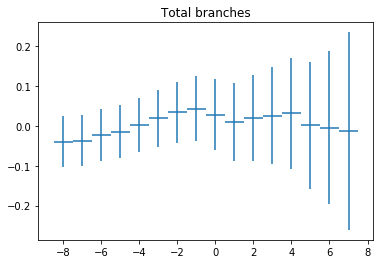

In [9]:
# Figure 3: Exposure to consolidation and local branch levels
mean=fig3()[0]
std=fig3()[1]
plt.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
plt.title('Total branches')
plt.show()  

Text(0.5, 1.0, 'New Mortgages')

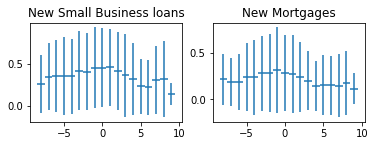

In [10]:
# Figure 4: Exposure to consolidation and the volume of new lending
mean1=fig4()[0]
std1=fig4()[1]
mean2=fig4()[2]
std2=fig4()[3]
plt.figure()
plt.subplot(2,2,1)
plt.errorbar(mean1.index, mean1, xerr=0.5, yerr=2*std1, linestyle='')
plt.title('New Small Business loans')
#plt.show() 
plt.subplot(2,2,2)
plt.errorbar(mean2.index, mean2, xerr=0.5, yerr=2*std2, linestyle='')
plt.title('New Mortgages')
#plt.show() 

Text(0.5, 1.0, 'New Mortgages')

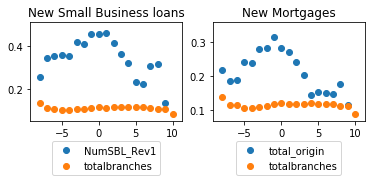

In [11]:
# Figure 5: The effect of subsequent bank entry on local credit supply
plt.figure()
# Hide warnings
warnings.filterwarnings("ignore")

## Small Business Lending
df = pd.read_stata('data/replication_input.dta')
df.drop_duplicates(keep='first', inplace=True)
df=df.assign(event_year=lambda df:df.year-df.yr_approve)
index=list(df)
dfmean = pd.DataFrame(columns=range(-8, 10), index=index)
#df['NumSBL_Rev1']=(df['NumSBL_Rev1']-df['NumSBL_Rev1'].mean())/df['NumSBL_Rev1'].std()
df['NumSBL_Rev1']=(df['NumSBL_Rev1']-df['NumSBL_Rev1'].min())/(df['NumSBL_Rev1'].max()-df['NumSBL_Rev1'].min())
df['totalbranches']=(df['totalbranches']-df['totalbranches'].min())/(df['totalbranches'].max()-df['totalbranches'].min())
for i in range(-8, 11):
    dfmean[i]=df.loc[(df['event_year']==i) & df['overlap']==1].mean()
dfmean=dfmean.T
mean=dfmean['NumSBL_Rev1']
plt.subplot(2,2,1)
plt.scatter(mean.index, mean)
plt.subplot(2,2,1)
plt.scatter(mean.index, dfmean['totalbranches'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.title('New Small Business loans')
#plt.show() 

## Mortgages
df = pd.read_stata('data/replication_input.dta')
df.drop_duplicates(keep='first', inplace=True)
df=df.assign(event_year=lambda df:df.year-df.yr_approve)
index=list(df)
dfmean = pd.DataFrame(columns=range(-8, 10), index=index)
#df['total_origin']=(df['total_origin']-df['total_origin'].mean())/df['total_origin'].std()
df['total_origin']=(df['total_origin']-df['total_origin'].min())/(df['total_origin'].max()-df['total_origin'].min())
df['totalbranches']=(df['totalbranches']-df['totalbranches'].min())/(df['totalbranches'].max()-df['totalbranches'].min())
for i in range(-8, 11):
    dfmean[i]=df.loc[(df['event_year']==i) & df['overlap']==1].mean()
dfmean=dfmean.T
mean=dfmean['total_origin']
plt.subplot(2,2,2)
plt.scatter(mean.index, mean)
plt.subplot(2,2,2)
plt.scatter(mean.index, dfmean['totalbranches'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.title('New Mortgages')
#plt.show() 

In [12]:
# Table 7: IV-Estimates of the effect of closings an local credit supply
df = pd.read_stata('data/replication_input.dta')
df.drop_duplicates(keep='first', inplace=True)
df=df.assign(event_year=lambda df:df.year-df.yr_approve)
index=list(df)
df['close_2yr']=0
df['close_2yr']=df['closed_branch'].loc[(df.event_year==0) | (df.event_year==1)]
df['close_2yr'].fillna(0, inplace=True)
df['POST']=df['event_year'].loc[df.event_year>0]
df['POST_close']=df.POST * df.close_2yr
df['POST_expose']= df.POST * df.overlap 

df['group_timeID']= df.groupby(['state_fps', 'cnty_fps', 'year']).grouper.group_info[0]
df['indivID']= df.groupby(['state_fps', 'cnty_fps', 'tractstring']).grouper.group_info[0]
df['clustID']= df.groupby(['state_fps', 'cnty_fps']).grouper.group_info[0] 

dummy = pd.get_dummies(df['year'])
chars = ['poptot', 'popdensity', 'pminority', 'pcollege', 'medincome', 'pincome', 'cont_totalbranches', 'cont_brgrowth'] 
for i in chars:
    for j in range(1999,2014):
        name=i+str(j)
        df[name]=0
        df[name]=df[i].loc[df['year']==j]
        
dftemp = df.filter(regex='poptot|popdensity|pminority|pcollege|medincome|pincome|cont_totalbranches|cont_brgrowth')
dftemp = dftemp.drop(chars, axis=1)  
controllist = list(dftemp)
controls = "+".join(controllist)
df[controllist] = df[controllist].fillna(0)
iID = pd.Categorical(df.indivID)
grID = pd.Categorical(df.group_timeID)
df = df.set_index(['indivID', 'group_timeID'])
df['iID'] = iID
df['grID'] = grID
df.to_csv('df_ols.csv')

In [13]:
# Again Try PanelOLS package
#exog_vars = controllist
#for i in chars:
#    colin=i+'2012'
#    exog_vars.remove(colin)
#exog_vars = chars
#exog_vars.append('POST_close')
#exog = sm.add_constant(df[exog_vars])
mod = PanelOLS(df.NumSBL_Rev1, df.POST_close, entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print('Panel A. OLS: %2.4f (%2.4f)'  %(res.params['POST_close'],res.std_errors['POST_close']))

Panel A. OLS: 7.3862 (1.4320)


## Independent contribution - Simulation Study

The general idea of this section is to test the identification framework with a stylized simulated Dataset. 

In [14]:
np.random.seed(123)
df=panel_sample()
df.to_csv('panel_sample.csv')

df['DD']=df.M*df.Exp
df['indivID']=df['iID'].copy()
df['gtID']=df['group_timeID'].copy()
df.set_index(['indivID', 'group_timeID'], inplace=True)

mod = PanelOLS(df.Y, df['D'], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print('The naiv approach, which should be biased \n %2.4f \n (%2.4f)' %(res.params,res.std_errors))

#mod1 = smf.ols('D ~ M + X', df)
mod1 = smf.ols('D ~ M', df)
res1 = mod1.fit()
df['predicted']=res1.predict()
mod2 = PanelOLS(df.Y, df.predicted, entity_effects=True, time_effects=True)
res2 = mod2.fit()
print('The naiv IV approach, which identifies the DGP \n First stage: \n %2.4f \n (%2.4f) \n Second stage: \n %2.4f \n (%2.4f)' %(res1.params['M'],res1.bse['M'],res2.params,res2.std_errors))

mod = PanelOLS(df.Y, df['DD'], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print('The reduced form (DD) with Exposure to merger as instrument \n %2.4f \n (%2.4f)' %(res.params,res.std_errors))

mod = PanelOLS(df.Y, df[['DD','X']], entity_effects=True, time_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print('The reduced form (DD) with Exposure to merger as instrument and control variables \n %2.4f \n (%2.4f)' %(res.params[0],res.std_errors[0]))
print('Note: the true effect is 0.5 thus the authors framework should yield reliable results \n \n')

df['indivID']=df['iID'].copy()
df['year']=df['t'].copy()
df.set_index(['indivID', 'year'], inplace=True)
mod1 = PanelOLS(df.D, df[['M','X']],entity_effects=True, time_effects=True)
res1 = mod1.fit()
df['predicted']=res1.predict()
df['indivID']=df['iID'].copy()
df['group_timeID']=df['gtID'].copy()
df.set_index(['indivID', 'group_timeID'], inplace=True)
mod2 = PanelOLS(df.Y, df.predicted, entity_effects=True, time_effects=True)
res2 = mod2.fit()
print('The authors IV approach, which includes time-varying tract controls \n First stage: \n %2.4f \n (%2.4f) \n Second stage: \n %2.4f \n (%2.4f)' %(res1.params['M'],res1.std_errors['M'],res2.params,res2.std_errors))

The naiv approach, which should be biased 
 1.9366 
 (0.0042)
The naiv IV approach, which identifies the DGP 
 First stage: 
 0.5022 
 (0.0140) 
 Second stage: 
 0.9725 
 (0.1160)
The reduced form (DD) with Exposure to merger as instrument 
 0.4884 
 (0.0658)
The reduced form (DD) with Exposure to merger as instrument and control variables 
 0.4897 
 (0.0660)
Note: the true effect is 0.5 thus the authors framework should yield reliable results
The authors IV approach, which includes time-varying tract controls 
 First stage: 
 0.5066 
 (0.0238) 
 Second stage: 
 0.9700 
 (0.1148)


## References

*Akerlof, G. A. (1970). The market for lemons: Quality and the market mechanism. Quarterly. Journal Economics, 84, 488-500.*

*Degryse, H., & Ongena, S. (2005). Distance, lending relationships, and competition. The Journal of Finance, 60(1), 231-266.*

*Frölich, M., & Sperlich, S. (2019). Impact evaluation. Cambridge University Press.*

*Nguyen, H. L. Q. (2019). Are credit markets still local? evidence from bank branch closings. American Economic Journal: Applied Economics, 11(1), 1-32.*

*Petersen, M. A., & Rajan, R. G. (2002). Does distance still matter? The information revolution in small business lending. The journal of Finance, 57(6), 2533-2570.*

*Stiglitz, J. E., & Weiss, A. (1981). Credit rationing in markets with imperfect information. The American economic review, 71(3), 393-410.*

*Wooldridge, J. M. (2015). Introductory econometrics: A modern approach. Nelson Education.*